In [1]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import numpy as np
from torch.utils.data import DataLoader
import math as m


In [2]:
dataset = datasets.MNIST(root='dataset/', train=True, transform=transforms.ToTensor(), download=True)

validation_set_size = int(0.1 * len(dataset))
train_set_size = len(dataset) - validation_set_size

# Split the dataset into train and validation sets
train_dataset, validation_dataset = torch.utils.data.random_split(dataset, [train_set_size, validation_set_size])

100%|██████████| 9912422/9912422 [00:00<00:00, 103494768.08it/s]


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 67447490.99it/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26539256.52it/s]


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 12394618.59it/s]


Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [3]:
print(len(train_dataset), len(validation_dataset))

54000 6000


In [4]:
import matplotlib.pyplot as plt

In [5]:
import torch.nn.functional as F

In [6]:
torch.tensor([1,2,3])

tensor([1, 2, 3])

In [7]:
# W, b = get_lin_layer(728, 128)

device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")

In [8]:
class LinLayer():
    def __init__(self, in_size=-1, out_size=-1, weights=None):
        if weights is None:
            std_dev = (2 / (in_size + out_size)) ** 0.5
            self.W = (torch.randn(in_size, out_size) * std_dev).to(device)
            k = 1/in_size
            # Bias init as ~Unif(-k,k), k = 1/in_size
            self.b = ((-m.sqrt(k) - m.sqrt(k)) * torch.rand(out_size) + m.sqrt(k)).to(device)
            # Bias initialized to 0.
    #         self.b = torch.zeros(out_size, dtype=torch.float32)
        else:
            self.W = weights['W']
            self.b = weights['b']
        
    def forward(self, x):
        y = torch.matmul(x, self.W) + self.b
        return y
        
    def __call__(self, x):
        return self.forward(x)

In [9]:
# class ReLULayer():
#     def forward(self, x):
#         return F.relu(x)
        
#     def __call__(self, x):
#         return self.forward(x)
    
    
# class SigmoidLayer():
#     def forward(self, x):
#         return F.sigmoid(x)
        
#     def __call__(self, x):
#         return self.forward(x)

In [10]:
class NeuralNet():
    def __init__(self, in_size, hidden_sizes=None, out_size=-1, weight_dictionaries=None):
        self.in_size = in_size
        self.layers = []
        if weight_dictionaries is None:
            
            for i, hs in enumerate(hidden_sizes):
                self.layers.append(LinLayer(in_size, hs))
                self.layers.append(F.relu)
                in_size = hs
            self.layers.append(LinLayer(in_size, out_size))
            # uncomment if you use a different fit than CE (which considers Sigmoid internally)
            # self.layers.append(F.sigmoid()) 
        else:
            for i, w_b in enumerate(weight_dictionaries):
                self.layers.append(LinLayer(weights=w_b))
                self.layers.append(F.relu)
            # self.layers.append(F.sigmoid()) 

    def forward(self, x):
        x = x.view(x.size(0), -1)
        for layer in self.layers:
            x = layer(x)
        return x
        
    def __call__(self,x):
        return self.forward(x)
        

In [11]:
nn = NeuralNet(784, [128,64], 10)

In [12]:
batch_size = 1024
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle=True)

In [13]:
batch = next(iter(train_dataloader))
# nn(batch[0])

In [28]:
class Population():
    
    def __init__(self, pop_size, in_size, hidden_sizes, out_size,):
        self.fit_criteria = F.cross_entropy
        self.pop_size = pop_size
        self.models = np.array([NeuralNet(in_size, hidden_sizes, out_size) for i in range(pop_size)])
    
    def get_fitness(self, x, y):
        '''
        Returns the fit for each individual. The fitness function is the Cross Entropy Loss,
        therefore a low value results in a high fit. 
        '''
        # get the output for each NN (shape: [pop_size, batch, 10])
        pop_outputs = torch.stack([net(x) for net in self.models], dim=0)

        # get the fitness for each NN (shape: [pop_size,])
        pop_fitness = torch.stack([self.fit_criteria(output, y) for output in pop_outputs], dim=0)
        
        return pop_fitness
    
    def get_subpop_fitness(self, sub_pop, x, y):
        pop_outputs = torch.stack([net(x) for net in sub_pop], dim=0)
        pop_fitness = torch.stack([self.fit_criteria(output, y) for output in pop_outputs], dim=0)
        return pop_fitness
    
    def roulette_wheel_selection():
        pass
    
    def tournament_selection(self, tournament_size, selection_size, x, y, fitness_kind='min'):
        '''
        Selects selection_size individuals with the roulette wheel algorithm using tournaments of 
        size tournament_size. fittness_kind is set to 'min', if a low fitness value is a high fitness 
        (for exmaple when a loss is used as fitness). It should be set to 'max' when a high value is a
        high fitness.
        '''
        fitness = self.get_fitness(x,y)
        fittest_indices = []
        for i in range(selection_size):
            tournament_indices = np.random.choice(self.pop_size, size=tournament_size, replace=False)
            # Careful: the fitness is negated if fitness_kind is set to min and then argmax is used.
            # Alternatively could use argmin, but it does not generalize.
            tournament_fitness = fitness[tournament_indices] * (-1 if fitness_kind=='min' else 1)
            best_indx = tournament_indices[np.argmax(tournament_fitness.cpu())]
#             print(best_indx)
            fittest_indices.append(best_indx)
    
        return np.array((fittest_indices)), fitness
    
    def get_random_pairing(self, parents_indices):
        
        num_parents = len(parents_indices)
        if num_parents % 2 != 0:
            print('Provide an even number of parents. Failed to create pairs')
            return None 
        np.random.shuffle(parents_indices)
        
        return np.array([(parents_indices[i], 
                         parents_indices[i + 1]) for i in range(0, num_parents, 2)])
    
    def _average_crossover(self, parent1, parent2):
        '''
        Averages the weights (W and b) in the two given neural networks and produces a single child.
        '''
        weight_dicts = []
        for layer1, layer2  in zip([l for l in parent1.layers if type(l) == LinLayer],
                          [l for l in parent2.layers if type(l) == LinLayer]):
            weight_dicts.append({'W': (layer1.W + layer2.W)/2, 'b':  (layer1.b + layer2.b)/2})
            
        child = NeuralNet(in_size = parent1.in_size, weight_dictionaries=weight_dicts)
        return child
    
    def _two_point_crossover_tensor(self, t1,t2):
        child1 = torch.zeros_like(t1)
        child2 = torch.zeros_like(t1)

        for j in range(t1.shape[1]):
            co_point1 = np.random.randint(1, t1.shape[0])
            co_point2 = np.random.randint(1, t1.shape[0])

            if co_point1 > co_point2:
                co_point1, co_point2 = co_point2, co_point1


#             print(co_point1, co_point2)
            child1[:,j] = torch.concat((t1[:co_point1,j], t2[co_point1:co_point2,j], t1[co_point2:,j]))
            child2[:,j] = torch.concat((t2[:co_point1,j], t1[co_point1:co_point2,j], t2[co_point2:,j]))

        return child1, child2
    
    def _two_point_crossover(self, parent1, parent2):
        weight_dicts1 = []
        weight_dicts2 = []
        for layer1, layer2  in zip([l for l in parent1.layers if type(l) == LinLayer],
                          [l for l in parent2.layers if type(l) == LinLayer]):
            W1, W2 = self._two_point_crossover_tensor(layer1.W, layer2.W)
            b1, b2 = self._two_point_crossover_tensor(layer1.b.reshape(-1,1), layer2.b.reshape(-1,1))
            b1, b2 = b1.reshape(-1), b2.reshape(-1)
            
            weight_dicts1.append({'W': W1, 'b':  b1})
            weight_dicts2.append({'W': W2, 'b':  b2})
            
        child1 = NeuralNet(in_size = parent1.in_size, weight_dictionaries=weight_dicts1)
        child2 = NeuralNet(in_size = parent1.in_size, weight_dictionaries=weight_dicts2)
        return child1, child2 
    
    def mutate_tensor(tensor, mutation_rate=0.01, mutation_scale=0.1):
        '''
        Mutates the given tensor with a mutation_rate chance for each value.
        The values are mutated with an additive noise ~N(0,1)*mutation_scale.
        Side effect: mutates the given tensor
        '''
        tensor_mutated = tensor.clone().detach().to(device)
        
        mask = (torch.rand(tensor.shape) < mutation_rate).to(device)

        # Generate random mutations for the masked values with ~N(0,1) * scale
        mutations = torch.randn(tensor.shape).to(device) * mutation_scale
        # Apply mutations in-place
        tensor_mutated += mask * mutations
        return tensor_mutated
    
    def mutate_weights(neural_net, mutation_rate=0.01, mutation_scale=0.1):
        '''
        Mutates each weights matrix (W and b) for each layer of the given neural net.
        '''
        for layer in [l for l in neural_net.layers if type(l) == LinLayer]:
            layer.W = Population.mutate_tensor(layer.W, mutation_rate, mutation_scale)
            layer.b = Population.mutate_tensor(layer.b, mutation_rate, mutation_scale)
    
    def crossover(self, parent_pairs, cr_rate=0.8, mutation_rate=0.01, mutation_scale=0.1, cross_over_type='average'):
        '''
        Generates a new population of offsprings given a list of pairs of parent indices.
        The output size is half of the given population. 
        '''
        offsprings = []
        
        for i, (p1_indx, p2_indx) in enumerate(parent_pairs):
            rand_num = np.random.rand()
            if rand_num <= cr_rate:
                # crossover
                if cross_over_type == 'average':
                    child = self._average_crossover(self.models[p1_indx], 
                                                self.models[p2_indx])
                    # mutate child
                    Population.mutate_weights(child, mutation_rate, mutation_scale)
                    offsprings.append(child)
                    
                elif cross_over_type == 'two_point':
                    child1, child2 = self._two_point_crossover(self.models[p1_indx],
                                                     self.models[p2_indx])
                    Population.mutate_weights(child1, mutation_rate, mutation_scale)
                    Population.mutate_weights(child2, mutation_rate, mutation_scale)
                    offsprings.append(child1)
                    offsprings.append(child2)
                else:
                    print('unknow crossover')
                    break
                    
                
            else:
                # no crossover, randomly append one of the two parents
                if cross_over_type == 'two_point':
                    offsprings.append(self.models[p1_indx])
                    offsprings.append(self.models[p2_indx])
                else:
                    offsprings.append(self.models[np.random.choice([p1_indx, p2_indx])])
        return np.array(offsprings)

    
    def elitism_replacement(self, offsprings, old_gen_fitness, offsprings_fitness, parents_to_keep_rateo=0.1, fitness_kind='min'):
        '''
        Generates a new population given the old population and the new offsprings.
        Offsprings and the old populations are supposed to have the same size, in order for the output to 
        maintain the size.
        parents_to_keep_rateo controls the percentage of elites from the previous population that will be kept.
        If fitness_kind is set to 'min', then individuals with the lowest value are considered to have a high fitness.
        '''
        children_to_keep_rateo = 1.0 - parents_to_keep_rateo
        parents_to_keep = m.ceil(self.pop_size * parents_to_keep_rateo)
        children_to_keep = m.floor(self.pop_size * children_to_keep_rateo)
        
        if fitness_kind =='min':
            selected_old_gen = self.models[torch.argsort(old_gen_fitness.cpu())][:parents_to_keep]
            selected_offsprings = offsprings[torch.argsort(offsprings_fitness.cpu())][:children_to_keep]        
        else:
            selected_old_gen = self.models[torch.flip(torch.argsort(old_gen_fitness), dims=(0,))][:parents_to_keep]
            selected_offsprings = offsprings[torch.flip(torch.argsort(offsprings_fitness), dims=(0,))][:children_to_keep]
            
#         print(type(selected_offsprings))
        return np.concatenate([selected_old_gen, selected_offsprings])


    def eval(self, x, y,ensemble_size=1):
        fitness = self.get_fitness()


In [73]:
pop = Population(100, 784, [128, 32], 10)

In [74]:
def print_and_flush(data, bar_length=50):
    print(f'\r Fitness: {data}', end='', flush=True)

In [75]:
# Training
num_epochs = 20
generations_fitnesses_avg = []
generations_fitnesses_min = []

val_fittnesses = []

for epoch in range(num_epochs):
    for i, batch in enumerate(train_dataloader):
        # Selection -------------------------------------------------------------
        sel_size = 200 if i % 2 == 0 else 100
        # average crossover generates half the size of offsprings,
        # while two_point generates as many offsprings as parents
        cross_type = 'average' if i % 2 == 0 else 'two_point'
        
        fit_indices, old_pop_fitness = pop.tournament_selection(tournament_size=20, 
                                                                selection_size=sel_size, 
                                                                x=batch[0].to(device), 
                                                                y=batch[1].to(device))
        fit_pairs = pop.get_random_pairing(fit_indices)
        
        # Crossover and mutations ------------------------------------------------
        offsprings = pop.crossover(fit_pairs, cr_rate=0.95, 
                                   mutation_rate=0.01, 
                                   mutation_scale=0.1, 
                                   cross_over_type=cross_type)
#         print(offsprings.shape)
        offsprings_fitness = pop.get_subpop_fitness(offsprings, x=batch[0].to(device), y=batch[1].to(device))
        
        # Replacement ------------------------------------------------------------
        new_pop = pop.elitism_replacement(offsprings, 
                                          old_pop_fitness, 
                                          offsprings_fitness, 
                                          parents_to_keep_rateo=0.5, 
                                          fitness_kind='min')
        pop.models = new_pop
        
        generations_fitnesses_avg.append((old_pop_fitness.sum()/old_pop_fitness.shape[0]).item())
        generations_fitnesses_min.append(old_pop_fitness.min())
        
        ## Print
        print(f'[Epoch:step][{epoch}/{num_epochs}:{i}/{len(train_dataloader)}]Gen fitness: {generations_fitnesses_min[-1]}.')
#         print_and_flush(str(generations_fitnesses_min[-1]) + " \t Epoch:" + str(epoch))
        ## Validation every X steps
    
        if i % 5 == 5-1 or i == len(train_dataloader)-1:
            tot_val_loss = 0
            for _, batch in enumerate(val_dataloader):
                pop_val_fits = pop.get_fitness(batch[0].to(device), batch[1].to(device))
                tot_val_loss += (pop_val_fits.sum()/pop_val_fits.shape[0])

            avg_val_loss = tot_val_loss / len(val_dataloader)
            val_fittnesses.append(avg_val_loss)
            
            print(f'\t Val fit: {avg_val_loss}')
        
       

[Epoch:step][0/20:0/53]Gen fitness: 2.2878262996673584.
[Epoch:step][0/20:1/53]Gen fitness: 2.275242567062378.
[Epoch:step][0/20:2/53]Gen fitness: 2.259108066558838.
[Epoch:step][0/20:3/53]Gen fitness: 2.2587645053863525.
[Epoch:step][0/20:4/53]Gen fitness: 2.2414352893829346.
	 Val fit: 2.249469518661499
[Epoch:step][0/20:5/53]Gen fitness: 2.234196186065674.
[Epoch:step][0/20:6/53]Gen fitness: 2.2182538509368896.
[Epoch:step][0/20:7/53]Gen fitness: 2.206686496734619.
[Epoch:step][0/20:8/53]Gen fitness: 2.2181408405303955.
[Epoch:step][0/20:9/53]Gen fitness: 2.1993298530578613.
	 Val fit: 2.2102344036102295
[Epoch:step][0/20:10/53]Gen fitness: 2.1843106746673584.
[Epoch:step][0/20:11/53]Gen fitness: 2.181337356567383.
[Epoch:step][0/20:12/53]Gen fitness: 2.176151990890503.
[Epoch:step][0/20:13/53]Gen fitness: 2.1763293743133545.
[Epoch:step][0/20:14/53]Gen fitness: 2.161646604537964.
	 Val fit: 2.166983127593994
[Epoch:step][0/20:15/53]Gen fitness: 2.1460375785827637.
[Epoch:step][0/20

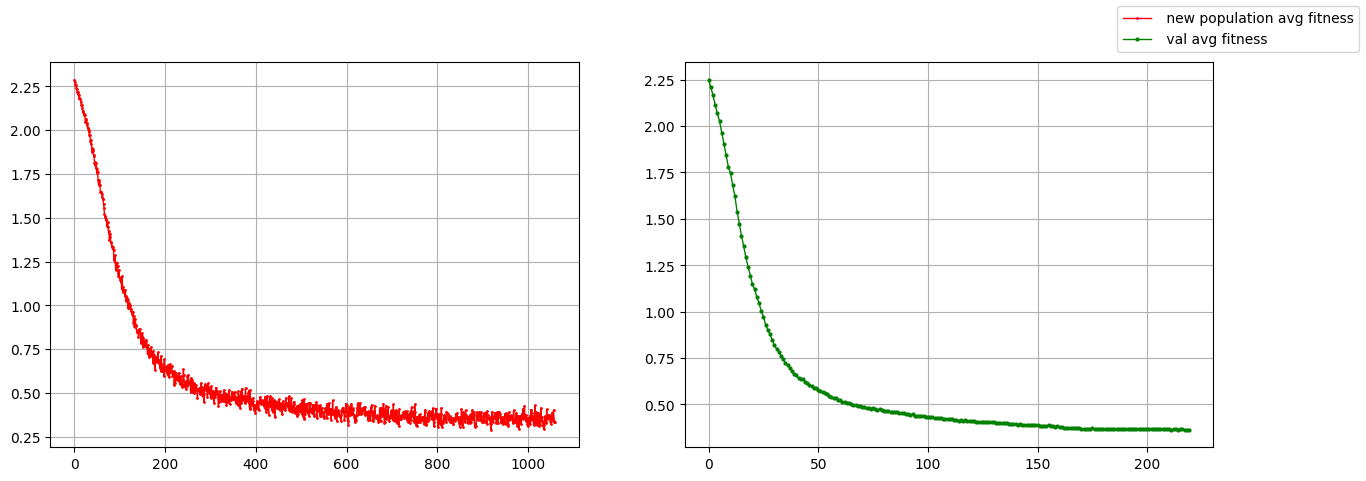

In [86]:
fig, ax = plt.subplots(1,2, figsize=(15, 5))

y_train = [fit.cpu() for fit in generations_fitnesses_min]
# x_larger = range(len(y_train))

y_val = [val_fit.cpu() for val_fit in val_fittnesses]
# x_smaller = range(0, len(y_train), 5)[:len(y_val)]


ax[0].plot(y_train, label=' new population avg fitness', 
           marker='o',
           linewidth=1, 
           markersize=1, color='r')
ax[1].plot(y_val, label=' val avg fitness', 
           marker='o',
           linewidth=1, 
           markersize=2, color='g')


ax[0].grid()
ax[1].grid()
fig.legend()
fig.show()

In [87]:
# fig, ax = plt.subplots(figsize=(10, 6))
# ax.plot(generations_fitnesses_min, label=' new population avg fitness', marker='o',linewidth=1, markersize=2)

# ax.grid()
# fig.legend()
# fig.show()

In [88]:
pop_outputs = torch.stack([net(batch[0].to(device)) for net in pop.models], dim=0)
top_indx = pop.get_fitness(batch[0].to(device), batch[1].to(device)).argmin()

In [89]:
(torch.argmax(pop_outputs, dim=2)[top_indx] == batch[1].to(device)).float().mean()

tensor(0.9102, device='cuda:0')

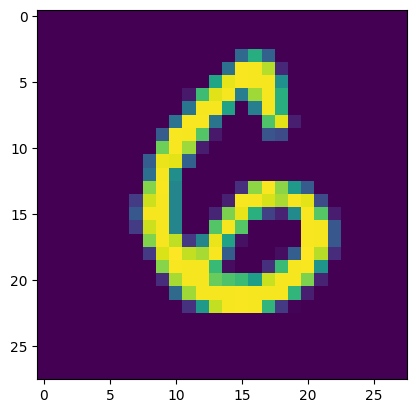

In [90]:
plt.imshow(np.transpose(batch[0][42], (1,2,0)))

In [91]:
torch.argmax(pop_outputs[0][42])

tensor(6, device='cuda:0')

In [154]:
pop_outputs.shape

torch.Size([100, 608, 10])

In [186]:
# torch.argmax(pop_outputs, dim=2).shape